In [1]:
import pandas as pd

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

import numpy as np
from sklearn.metrics import classification_report

C:\Users\assas\AppData\Local\Temp\ipykernel_18356\3296178993.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\assas\anaconda3\envs\ML_development\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
LR = 2e-5
EPOCHS = 1
BATCH_SIZE = 16
MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
MAX_TRAINING_EXAMPLES = -1 # set this to -1 if you want to use the whole training set

In [4]:
train = pd.read_csv('../csv/tweet-sentiment-train.csv')
x_train = train['Tweet']
y_train = train['Label'].replace({"Negatif": 0, "Nötr": 1, "Pozitif": 2})
test = pd.read_csv('../csv/tweet-sentiment-test.csv')
x_test = test['Tweet']
y_test = test['Label'].replace({"Negatif": 0, "Nötr": 1, "Pozitif": 2})

C:\Users\assas\AppData\Local\Temp\ipykernel_18356\2164879038.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = train['Label'].replace({"Negatif": 0, "Nötr": 1, "Pozitif": 2})
C:\Users\assas\AppData\Local\Temp\ipykernel_18356\2164879038.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = test['Label'].replace({"Negatif": 0, "Nötr": 1, "Pozitif": 2})


In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, force_download=True)

config.json: 100%|██████████| 841/841 [00:00<?, ?B/s] 
sentencepiece.bpe.model: 100%|██████████| 5.07M/5.07M [00:00<00:00, 11.1MB/s]
special_tokens_map.json: 100%|██████████| 150/150 [00:00<?, ?B/s] 


In [6]:
x_train = x_train.apply(lambda x: tokenizer(x, truncation=True, padding='max_length', max_length=256))
x_test = x_test.apply(lambda x: tokenizer(x, truncation=True, padding="max_length", max_length=256))

In [7]:
x_train.reset_index(drop=True, inplace=True)

In [8]:
x_test.reset_index(drop=True, inplace=True)

max_tok = 0
for i in x_train:
    if len(i['input_ids']) > max_tok:
        max_tok = len(i['input_ids'])
max_tok
3549

max_tok = 0
for i in x_val:
    if len(i['input_ids']) > max_tok:
        max_tok = len(i['input_ids'])
max_tok
2241

max_tok = 0
for i in x_test:
    if len(i['input_ids']) > max_tok:
        max_tok = len(i['input_ids'])
max_tok
1331

In [9]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {"input_ids": torch.tensor(self.encodings[idx]["input_ids"])}
        item['attention_mask'] = torch.tensor(self.encodings[idx]["attention_mask"])
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)

In [11]:
training_args = TrainingArguments(
    output_dir='./results',                   # output directory
    num_train_epochs=EPOCHS,                  # total number of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=100,                         # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                        # strength of weight decay
    logging_dir='./logs',                     # directory for storing logs
    logging_steps=10,                         # when to print log
)

model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

pytorch_model.bin: 100%|██████████| 1.11G/1.11G [00:43<00:00, 25.5MB/s]


In [12]:
trainer = Trainer(
    model=model,                              # the instantiated 🤗 Transformers model to be trained
    args=training_args,                       # training arguments, defined above
    train_dataset=train_dataset,              # training dataset
)

trainer.train()

  5%|▌         | 10/186 [00:10<02:46,  1.06it/s]

{'loss': 0.7519, 'learning_rate': 5e-06, 'epoch': 0.05}


 11%|█         | 20/186 [00:19<02:34,  1.07it/s]

{'loss': 0.671, 'learning_rate': 1e-05, 'epoch': 0.11}


 16%|█▌        | 30/186 [00:29<02:26,  1.07it/s]

{'loss': 0.4815, 'learning_rate': 1.5e-05, 'epoch': 0.16}


 22%|██▏       | 40/186 [00:38<02:16,  1.07it/s]

{'loss': 0.35, 'learning_rate': 2e-05, 'epoch': 0.22}


 27%|██▋       | 50/186 [00:47<02:07,  1.07it/s]

{'loss': 0.6146, 'learning_rate': 2.5e-05, 'epoch': 0.27}


 32%|███▏      | 60/186 [00:57<01:57,  1.07it/s]

{'loss': 0.4974, 'learning_rate': 3e-05, 'epoch': 0.32}


 38%|███▊      | 70/186 [01:06<01:48,  1.07it/s]

{'loss': 0.4203, 'learning_rate': 3.5e-05, 'epoch': 0.38}


 43%|████▎     | 80/186 [01:15<01:39,  1.07it/s]

{'loss': 0.4036, 'learning_rate': 4e-05, 'epoch': 0.43}


 48%|████▊     | 90/186 [01:25<01:29,  1.07it/s]

{'loss': 0.3572, 'learning_rate': 4.5e-05, 'epoch': 0.48}


 54%|█████▍    | 100/186 [01:34<01:20,  1.07it/s]

{'loss': 0.4882, 'learning_rate': 5e-05, 'epoch': 0.54}


 59%|█████▉    | 110/186 [01:43<01:11,  1.07it/s]

{'loss': 0.4792, 'learning_rate': 4.418604651162791e-05, 'epoch': 0.59}


 65%|██████▍   | 120/186 [01:53<01:01,  1.07it/s]

{'loss': 0.3262, 'learning_rate': 3.837209302325582e-05, 'epoch': 0.65}


 70%|██████▉   | 130/186 [02:02<00:52,  1.07it/s]

{'loss': 0.3559, 'learning_rate': 3.2558139534883724e-05, 'epoch': 0.7}


 75%|███████▌  | 140/186 [02:11<00:43,  1.06it/s]

{'loss': 0.3757, 'learning_rate': 2.674418604651163e-05, 'epoch': 0.75}


 81%|████████  | 150/186 [02:21<00:33,  1.07it/s]

{'loss': 0.4142, 'learning_rate': 2.0930232558139536e-05, 'epoch': 0.81}


 86%|████████▌ | 160/186 [02:30<00:24,  1.07it/s]

{'loss': 0.376, 'learning_rate': 1.5116279069767441e-05, 'epoch': 0.86}


 91%|█████████▏| 170/186 [02:40<00:15,  1.06it/s]

{'loss': 0.3105, 'learning_rate': 9.302325581395349e-06, 'epoch': 0.91}


 97%|█████████▋| 180/186 [02:49<00:05,  1.07it/s]

{'loss': 0.3523, 'learning_rate': 3.488372093023256e-06, 'epoch': 0.97}


100%|██████████| 186/186 [02:54<00:00,  1.07it/s]

{'train_runtime': 174.4996, 'train_samples_per_second': 17.02, 'train_steps_per_second': 1.066, 'train_loss': 0.4467120055229433, 'epoch': 1.0}


TrainOutput(global_step=186, training_loss=0.4467120055229433, metrics={'train_runtime': 174.4996, 'train_samples_per_second': 17.02, 'train_steps_per_second': 1.066, 'train_loss': 0.4467120055229433, 'epoch': 1.0})

In [13]:
test_preds_raw, test_labels , _ = trainer.predict(test_dataset)
test_preds = np.argmax(test_preds_raw, axis=-1)
print(classification_report(test_labels, test_preds, digits=3))

100%|██████████| 21/21 [00:02<00:00,  8.15it/s]


              precision    recall  f1-score   support

           0      0.848     0.864     0.856       110
           1      1.000     0.927     0.962       110
           2      0.828     0.873     0.850       110

    accuracy                          0.888       330
   macro avg      0.892     0.888     0.889       330
weighted avg      0.892     0.888     0.889       330



<Axes: >

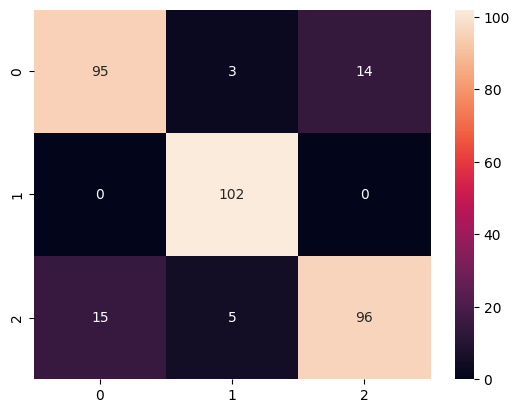

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(test_preds, test_labels),annot = True,fmt='d')

In [14]:
trainer.save_model("./results/sentiment_model") # save best model